# Model Analysis

In [1]:
import pickle
from glob import glob
from pathlib import Path
import scipy.sparse as sp
from tqdm.notebook import tqdm
from gensim.models.word2vec import Word2Vec
from packages.TPPMI.ppmi_model import PPMIModel
from packages.TPPMI.tppmi_model import TPPMIModel

from embedding_visualization import \
    plot_cosine_similarity, plot_cosine_similarity_tppmi, print_most_similar_cade

## Setup

In [2]:
model_path = Path("model/")
number_of_context_words = 500
ppmi_path = Path(f"data/ppmi-matrices/monthly/{number_of_context_words}")

In [3]:
model_static = Word2Vec.load(str(model_path / "static/word2vec.model"))

## Load models for months

In [4]:
# by months
cade_model_path_monthly = model_path / "monthly"
cade_model_monthly_filenames = glob(str(cade_model_path_monthly / "*.model"))

In [5]:
# load cade models
cade_models_monthly = {f"model_{model_file.split('_')[1][0:3].lower()}":Word2Vec.load(model_file) for model_file in tqdm(cade_model_monthly_filenames)}

  0%|          | 0/11 [00:00<?, ?it/s]

Order the models chronologically

In [6]:
order = ['jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']
month_codes = {"jun": 6, "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12, "jan": 1, "feb": 2, "mar": 3, "apr": 4}

# Sort the keys based on the desired month order
sorted_keys = sorted(cade_models_monthly.keys(), key=lambda x: order.index(x.split('_')[1]))

# Create a sorted dictionaries
models_monthly = {key: cade_models_monthly[key] for key in sorted_keys}

### TPPMI

In [7]:
ppmi_data_files = sorted(glob(str(ppmi_path  / "*.npz")))
words_files = sorted(glob(str(ppmi_path  / "*.pkl")))

Split context-words from timestamped-vocabularies

In [8]:
context_words_file = [path for path in words_files if "context-words" in path]
ppmi_vocab_files = [path for path in words_files if "context-words" not in path]

In [9]:
# Get ppmi-matrices and vocab
ppmi_matrices = {}

for filenames in zip(ppmi_vocab_files, ppmi_data_files):
    ppmi_matrix = sp.load_npz(filenames[1])
    with open(filenames[0], "rb") as f:
        vocab = pickle.load(f)
    key = filenames[0].split("ppmi-")[2][0:2]
    ppmi_matrices[key] = {"ppmi_matrix" : ppmi_matrix, "vocab": vocab}

# Get common context-words
with open(context_words_file[0], "rb") as f:
    context_words = pickle.load(f)

In [10]:
ppmi_matrices.keys()

dict_keys(['01', '02', '03', '04', '06', '07', '08', '09', '10', '11', '12'])

Create ppmi_model objects

In [11]:
ppmi_models = {key: PPMIModel.construct_from_data(ppmi_data["ppmi_matrix"], ppmi_data["vocab"], context_words) for key, ppmi_data in ppmi_matrices.items()}

In [12]:
tppmi_model = TPPMIModel(ppmi_models)

In [13]:
print(f"Size of the vocabulary: {tppmi_model.get_vocabulary_size()}")

Size of the vocabulary: 26301


## Elon Musk Twitter takeover

### Overview

Business magnate Elon Musk initiated an acquisition of American social media company Twitter, Inc. on April 14, 2022, and concluded it on October 27, 2022. Musk had begun buying shares of the company in January 2022, becoming its largest shareholder by April with a 9.1 percent ownership stake

source: [Wikipedia article](https://en.wikipedia.org/wiki/Acquisition_of_Twitter_by_Elon_Musk#:~:text=Business%20magnate%20Elon%20Musk%20initiated,a%209.1%20percent%20ownership%20stake.)

In [15]:
target_word_twitter = "twitter"
test_words_twitter = ["facebook",  "elon", "instagram"]

In [16]:
selected_months_twitter = ["sep", "oct", "nov", "dec", "jan"]
selected_models_monthly_twitter = {f"model_{month}": models_monthly[f"model_{month}"] for month in selected_months_twitter}

In [17]:
title_twitter = f"Evolution of the word {target_word_twitter} over time"
subtitle_twitter = f"Period: {' - '.join([month.capitalize() for month in selected_months_twitter])}"

In [18]:
print_most_similar_cade(selected_models_monthly_twitter, target_word_twitter)

Word: twitter
Month: Sep
[('facebook', 0.9325878024101257), ('tweet', 0.8852960467338562), ('page', 0.859761655330658)]
--------------------------------
Month: Oct
[('facebook', 0.9247101545333862), ('instagram', 0.806344747543335), ('sms', 0.7980491518974304)]
--------------------------------
Month: Nov
[('facebook', 0.8923001885414124), ('page', 0.7984558343887329), ('text', 0.7902755737304688)]
--------------------------------
Month: Dec
[('facebook', 0.852095365524292), ('musk', 0.8208754658699036), ('tweet', 0.7895939350128174)]
--------------------------------
Month: Jan
[('elon', 0.8899370431900024), ('amandamarcotte', 0.8567959666252136), ('musks', 0.8488495349884033)]
--------------------------------


### Temporaly changing embeddings

### Cosine similarities

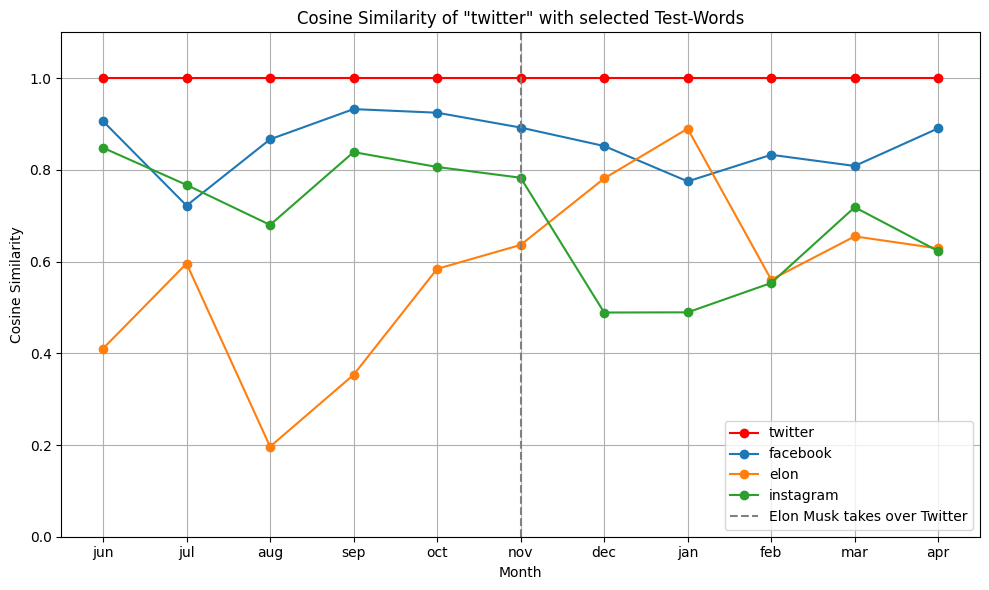

In [19]:
plot_cosine_similarity(target_word_twitter, test_words_twitter, models_monthly, "nov", "Elon Musk takes over Twitter")

### TPPMI

In [20]:
test_words_twitter

['facebook', 'elon', 'instagram']

In [21]:
tppmi_twitter = tppmi_model.get_tppmi(test_words_twitter + [target_word_twitter])

All words are contained in the vocabulary
elon - not in vocab of timestep: 06
elon - not in vocab of timestep: 08
elon - not in vocab of timestep: 09


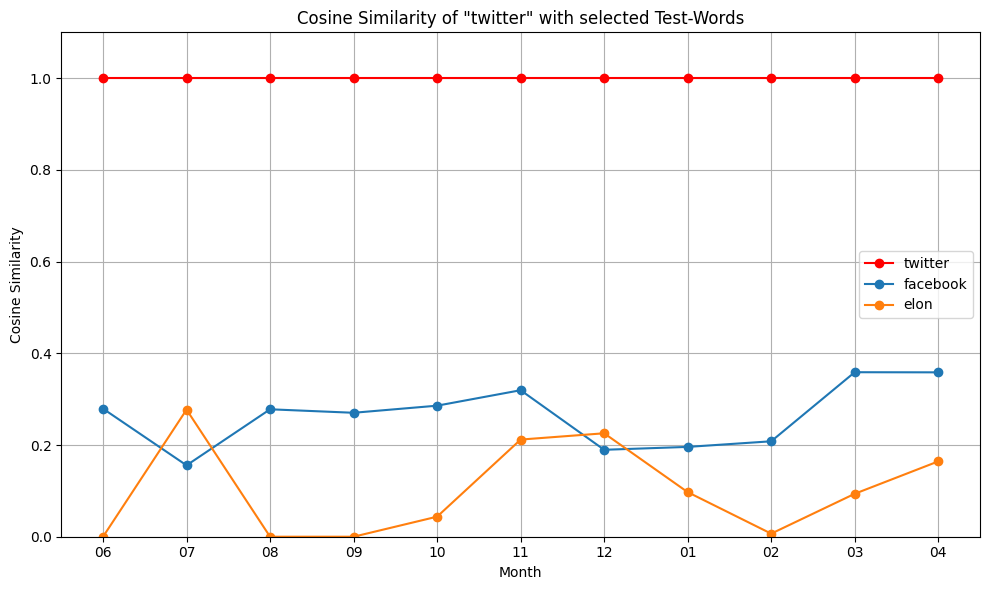

In [22]:
plot_cosine_similarity_tppmi("twitter", ["facebook", "elon"], tppmi_model)

## Mass Shootings

### Overview

- **May:** Uvalde Robb Elementary School shooting (May 24, 2022)
- **November:** Colorado Springs nightclub shooting (November 19, 2022)
- **March:** Nashville school shooting (March 27, 2023)

In [23]:
target_word_shootings = "shooting"

In [24]:
selected_months_shootings = ["jun", "jul", "aug", "sep", "oct", "nov"]
selected_models_monthly_shootings = {f"model_{month}": models_monthly[f"model_{month}"] for month in selected_months_shootings}

In [25]:
title_shootings = f"Evolution of the word {target_word_shootings} over time"
subtitle_shootings = f"Period: {' - '.join([month.capitalize() for month in selected_months_shootings])}"

In [26]:
print_most_similar_cade(models_monthly, target_word_shootings)

Word: shooting
Month: Jun
[('uvalde', 0.8860093355178833), ('texas', 0.7802619338035583), ('wsjcomarticlesdemoc', 0.7500583529472351)]
--------------------------------
Month: Jul
[('mass', 0.8167091012001038), ('robb', 0.8122766613960266), ('uvalde', 0.7859821319580078)]
--------------------------------
Month: Aug
[('massacre', 0.8483223915100098), ('mass', 0.8460655808448792), ('parkland', 0.8032575845718384)]
--------------------------------
Month: Sep
[('protests', 0.7818800210952759), ('murder', 0.7694730162620544), ('queens', 0.7689156532287598)]
--------------------------------
Month: Oct
[('robb', 0.8136457204818726), ('massacre', 0.7476783990859985), ('killed', 0.7434701323509216)]
--------------------------------
Month: Nov
[('parkland', 0.8928260803222656), ('teen', 0.8828899264335632), ('victim', 0.8613001704216003)]
--------------------------------
Month: Dec
[('coyotes', 0.7932825684547424), ('colorado', 0.7876253128051758), ('murder', 0.7869980931282043)]
----------------

### Temporarily changing embeddings

### Cosine similarities

In [27]:
target_word_shootings = "shooting"
test_words_shootings = ["uvalde", "colorado", "nashville"]

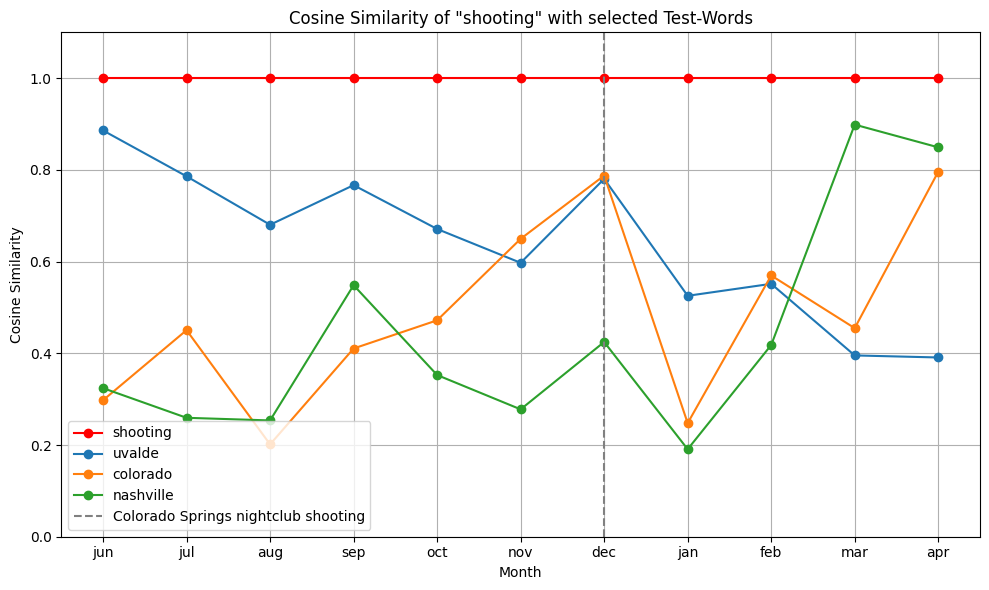

In [28]:
plot_cosine_similarity(target_word_shootings, test_words_shootings, models_monthly, event="dec", event_name="Colorado Springs nightclub shooting")

### TPPMI

In [29]:
tppmi_shootings = tppmi_model.get_tppmi(test_words_shootings + [target_word_shootings])

All words are contained in the vocabulary
nashville - not in vocab of timestep: 12
nashville - not in vocab of timestep: 01


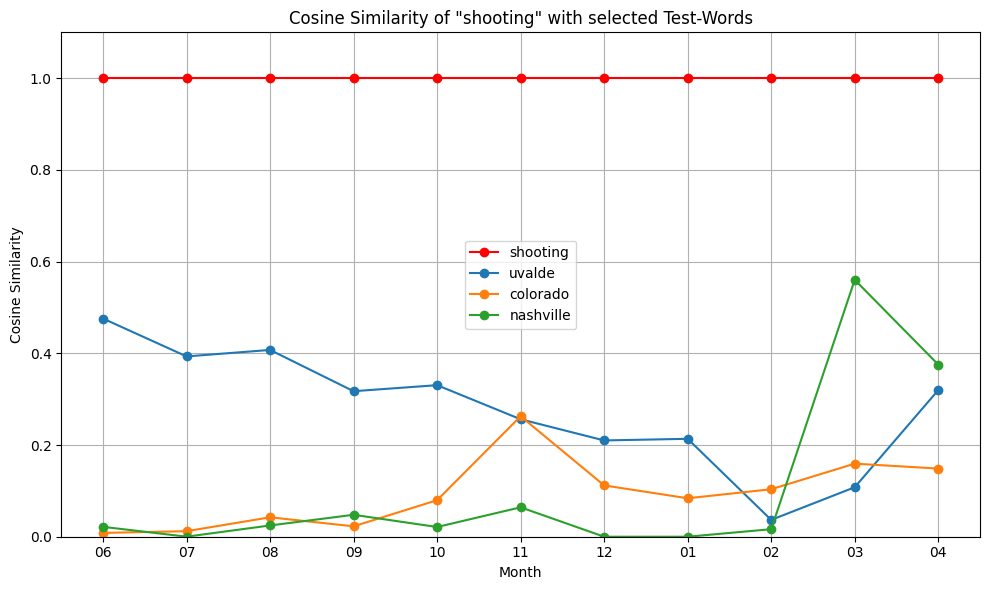

In [30]:
plot_cosine_similarity_tppmi(target_word_shootings, test_words_shootings, tppmi_model)

## President

### Overview

June:
- Boris Johnson: vote of no confidence June 6, 2022
- Lyndon B Johnson: Talks leading up to the civil rights act July 2, (1964)
- Janet Godwin: The Iowa City-based education testing company ACT will be laying off 106 employees by July 1.

September:
- Scott Hagel: Vice president of marketing

January:
- Richard Cordoray: Considered as vice chairman of the federal reserve for banking supervision

March/April:
- Donald Trump: Trump charged with 34 felony counts in hush money scheme

In [31]:
target_word = "president"
test_words = ["johnson", "trump", "biden", "desantis"]

In [32]:
title_colorado_springs = f"Evolution of the word {target_word} over time"

In [33]:
print_most_similar_cade(models_monthly, target_word)

Word: president
Month: Jun
[('former', 0.7764949798583984), ('johnson', 0.7447283267974854), ('godwin', 0.7293457388877869)]
--------------------------------
Month: Jul
[('joe', 0.7944174408912659), ('donald', 0.78546541929245), ('former', 0.754560649394989)]
--------------------------------
Month: Aug
[('former', 0.8239787817001343), ('chair', 0.8012738823890686), ('vice', 0.7905278205871582)]
--------------------------------
Month: Sep
[('hagel', 0.8144669532775879), ('chairman', 0.790585994720459), ('former', 0.7894874215126038)]
--------------------------------
Month: Oct
[('vice', 0.7888045310974121), ('leader', 0.7432360649108887), ('obama', 0.7343331575393677)]
--------------------------------
Month: Nov
[('chairman', 0.8192301392555237), ('leader', 0.81053227186203), ('mayor', 0.7648601531982422)]
--------------------------------
Month: Dec
[('chairman', 0.8314329385757446), ('chair', 0.8270971179008484), ('leader', 0.7758553624153137)]
--------------------------------
Month: J

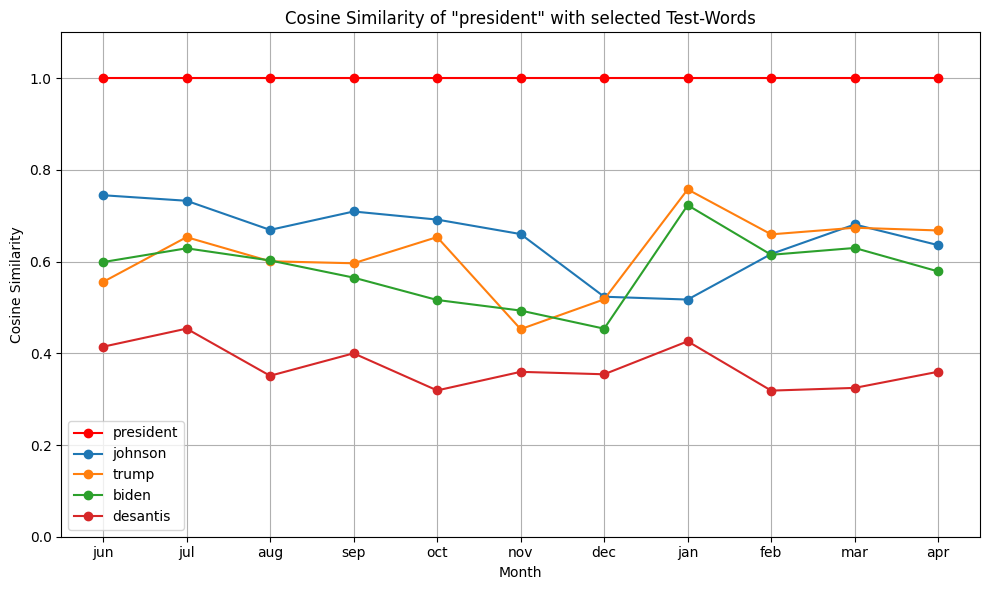

In [34]:
plot_cosine_similarity(target_word, test_words, models_monthly)

### TPPMI

In [35]:
tppmi_president = tppmi_model.get_tppmi(test_words + [target_word])

All words are contained in the vocabulary


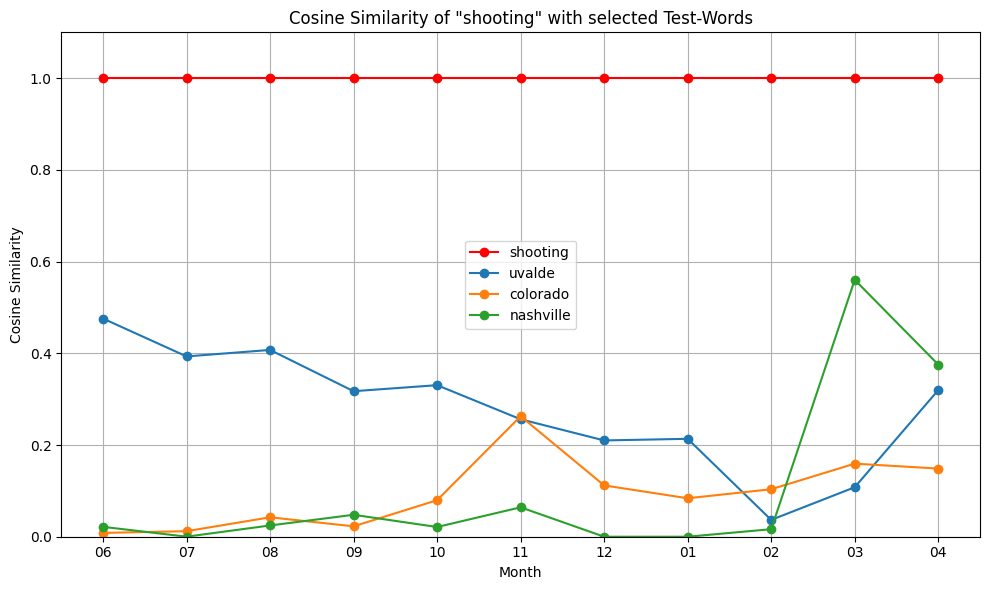

In [36]:
plot_cosine_similarity_tppmi(target_word_shootings, test_words_shootings, tppmi_model)